# Model evaluation

In this notebook, I will compare the accuracy metrics of models

In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import scienceplots  # noqa # pylint: disable=unused-import

plt.style.use(["science", "ieee", "default"])
plt.rcParams.update({"axes.grid": True})

In [4]:
from tqdm.auto import tqdm

## Prepare dataloader

In [5]:
from pathlib import Path

ROOT_DATA_DIR = Path("../data/")

In [6]:
from collections import defaultdict

import lightning.pytorch as pl
import torch
from lightning.pytorch import Trainer, seed_everything
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from torch import Tensor, nn
from torch.utils.data import DataLoader, TensorDataset

from src.utils import get_metrics

take only 1 dataset, 1 concrete time series for now...

In [7]:
DATA_DIR = ROOT_DATA_DIR / "KPI-Anomaly-Detection/Preliminary_dataset"

In [158]:
df = pd.read_parquet(DATA_DIR / "train.parquet")
df = df[df["KPI ID"] == "02e99bd4f6cfb33f"].copy()
df = df[df.index > 1.49 * 1e9].copy()
df = df.query("timestamp < 1496538120").copy()
df["time"] = df.index - df.index[0]
# df["value"] = df["value"].diff()
# df = df.query('stock==1 & day==0 & train==1')
# df.value = df.value.pct_change()
df.dropna(inplace=True)

In [159]:
def convert_to_windows(x, window_size):
    # convert input time series x to
    # time series of lags, first window_size observations are dropped
    windows = []
    for i in range(window_size, len(x)):
        w = x[i - window_size : i]
        windows.append(w)
    windows = np.array(windows)
    return windows

In [160]:
df["value_diff"] = df["value"].diff()
tr_cols = ["value", "value_diff"]
df = df.dropna()

In [161]:
# fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# plt.subplot(1, 2, 1)
# plt.plot(df.value.diff())
# plt.subplot(1, 2, 2)
# plt.hist(df.value)
# plt.yscale("log")
# plt.tight_layout();

In [162]:
window_size = 8
train_proportion = 0.9
batch_size = 16
learning_rate = 1e-5
epochs = 30

In [185]:
x = df[tr_cols].values.copy()
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
# x_scaled = x
x = convert_to_windows(x, window_size)
y = df["target"].values
y = y[window_size:]

# class_weights = compute_class_weight('balanced', classes=[0, 1], y=y.ravel())
# class_weights = class_weights / class_weights.sum()

x = torch.Tensor(x).float()
y = torch.Tensor(y).float()

train_idx = int(len(x) * train_proportion)
# train_idx = int(1.495 * 1e9)

tr, va = x[:train_idx], x[train_idx:]
# x = np.hstack([x, y.reshape(-1, 1)])
# y = y.reshape(-1, 1)
ytr, yva = y[:train_idx], y[train_idx:]
tr_dataset = TensorDataset(tr, ytr)
va_dataset = TensorDataset(va, yva)

In [186]:
# fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# plt.sca(axs[0])
# plt.plot(tr[:, 0, 0])
# plt.sca(axs[1])
# plt.plot(tr[:, 0, 1])
# fig.tight_layout();

## Evaluate models on 1 dataset

In [187]:
from src.utils import MetricTracker

In [13]:
from src.transformer import TransformerAnomalyDetector

### Scaled Dot-Product

In [189]:
window_size = 8
train_proportion = 0.9
batch_size = 2 * 4096
epochs = 100

In [190]:
seed_everything(1)

tr_dl = DataLoader(tr_dataset, batch_size=batch_size, shuffle=False)
va_dl = DataLoader(va_dataset, batch_size=batch_size, shuffle=False)

Global seed set to 1


In [191]:
len(tr_dl), len(va_dl), tr_cols

(6, 1, ['value', 'value_diff'])

> **TODO**: add positional enocding

In [169]:
seed_everything(1)

input_dim = len(tr_cols)

block_args = {
    "input_dim": 8,
    "num_heads": 2,
    "dim_feedforward": 2 * 8,
    "num_layers": 1,
    "enable_layer_norm": False,
}
positional_encoder_args = {
    "enable": False,
    "max_len": window_size,
}

loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5))

model_params = {
    "input_dim": input_dim,
    "block_input_dim": block_args["input_dim"],
    "block_args": block_args,
    "num_layers": block_args["num_layers"],
    "positional_encoder_args": positional_encoder_args,
    "learning_rate": 1e-1,
    "dropout": 0.0,
    "loss_fn": loss_fn,
}


model = TransformerAnomalyDetector(
    **model_params,
)

Global seed set to 1
positional encoding disabled
layer norm disabled


In [171]:
seed_everything(1)
trainer = pl.Trainer(
    max_epochs=epochs,
    log_every_n_steps=1,
    callbacks=[LearningRateFinder(), MetricTracker()],
)

trainer.fit(model, tr_dl, va_dl)

Global seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/th/Desktop/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/th/Desktop/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to impr

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.01445439770745928
Restoring states from the checkpoint path at /Users/th/Documents/icl_thesis/notebooks/.lr_find_05df8c2b-c3b7-43be-83ba-b931c00672e2.ckpt
Restored all states from the checkpoint at /Users/th/Documents/icl_thesis/notebooks/.lr_find_05df8c2b-c3b7-43be-83ba-b931c00672e2.ckpt

  | Name                | Type               | Params
-----------------------------------------------------------
0 | front_linear        | Linear             | 24    
1 | positional_encoder  | Identity           | 0     
2 | transformer_encoder | TransformerEncoder | 544   
3 | final_linear        | Linear             | 9     
4 | loss_fn             | BCEWithLogitsLoss  | 0     
-----------------------------------------------------------
577       Trainable params
0         Non-trainable params
577       Total params
0.002     Total estimated model params size (MB)
Restored all states from the checkpoint at /Users/th/Documents/i

Sanity Checking: 0it [00:00, ?it/s]

/home/th/Desktop/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [47]:
# %reload_ext tensorboard
# %tensorboard --logdir=lightning_logs/

In [48]:
mt = trainer.callbacks[1]

In [49]:
from copy import deepcopy

res = deepcopy(mt.collection)
for r in res:
    for k, v in r.items():
        if type(v) == torch.Tensor:
            r[k] = np.float32(v.cpu())
        else:
            r[k] = np.float32(v)
res = pd.DataFrame(res)

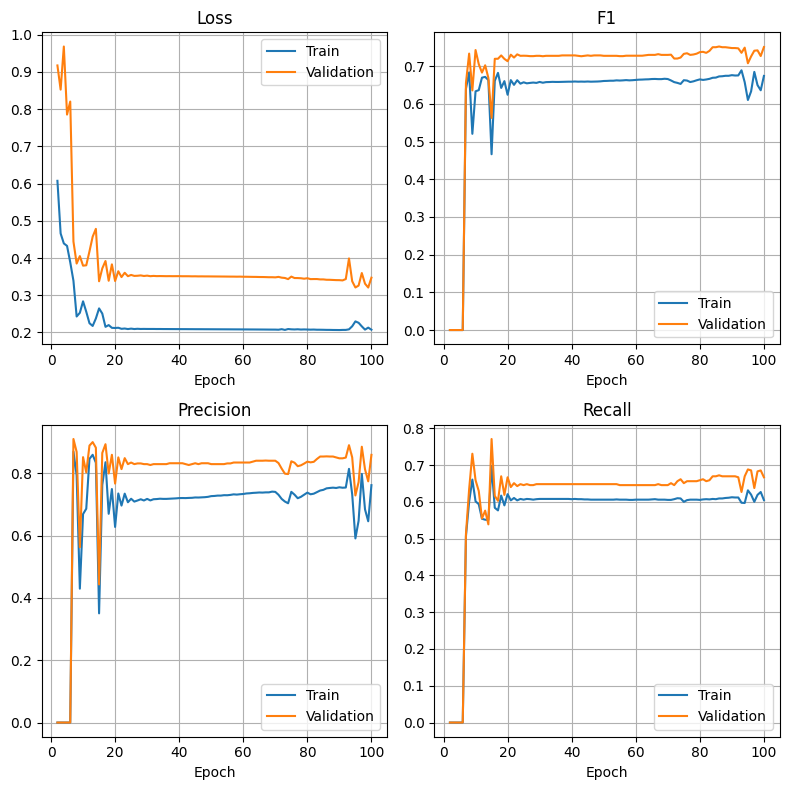

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

plt.sca(axs[0, 0])
plt.plot(res["train_loss"], label="Train")
plt.plot(res["val_loss"], label="Validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[0, 1])
plt.plot(res["train_f1"], label="Train")
plt.plot(res["val_f1"], label="Validation")
plt.title("F1")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[1, 0])
plt.plot(res["train_precision"], label="Train")
plt.plot(res["val_precision"], label="Validation")
plt.title("Precision")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[1, 1])
plt.plot(res["train_recall"], label="Train")
plt.plot(res["val_recall"], label="Validation")
plt.title("Recall")
plt.xlabel("Epoch")
plt.legend()
fig.tight_layout();

### export model weights

In [28]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
front_linear.weight 	 torch.Size([8, 2])
front_linear.bias 	 torch.Size([8])
transformer_encoder.layers.0.self_attn.qkv_proj.weight 	 torch.Size([24, 8])
transformer_encoder.layers.0.self_attn.o_proj.weight 	 torch.Size([8, 8])
transformer_encoder.layers.0.self_attn.o_proj.bias 	 torch.Size([8])
transformer_encoder.layers.0.linear_net.0.weight 	 torch.Size([16, 8])
transformer_encoder.layers.0.linear_net.0.bias 	 torch.Size([16])
transformer_encoder.layers.0.linear_net.3.weight 	 torch.Size([8, 16])
transformer_encoder.layers.0.linear_net.3.bias 	 torch.Size([8])
final_linear.weight 	 torch.Size([1, 8])
final_linear.bias 	 torch.Size([1])
loss_fn.pos_weight 	 torch.Size([])


https://stackoverflow.com/questions/2117313/initializing-constant-static-array-in-header-file

In [29]:
# template_params = 'const static char %s[];'
# with open('../vitis_hls/transformer/scaled_dp_params.h', 'w') as f:
#     for name, param in model.named_parameters():
#         n = name.upper()
#         # s = n.split('.')
#         n = n.replace('.', '_')
#         # p = [f'{x:.6f}' for x in param.ravel().detach().numpy()]
#         # p = ', '.join(p)
#         print(template_params % (n), file=f)

In [30]:
template_params = 'inline constexpr static double %s[%s] = {%s};'
with open('../vitis_hls/transformer/scaled_dp_params.h', 'w') as f:
    for name, param in model.named_parameters():
        n = name.upper()
        # s = param.size()
        n = n.replace('.', '_')
        p = [f'{x:.6f}' for x in param.ravel().detach().numpy()]
        l = len(p)
        p = ', '.join(p)
        print(template_params % (n, l, p), file=f)

In [194]:
xx = torch.tensor([[
    [-1, -1],
    [-1, 0],
    [-1, 1],
    [0, -1],
    [0, 0],
    [0, 1],
    [1, -1],
    [1, 1],
]]).float()
model(xx)

tensor([-380.4305], grad_fn=<SelectBackward0>)

In [197]:
xx.shape

torch.Size([1, 8, 2])

In [198]:
x.shape

torch.Size([46471, 8, 2])

In [199]:
model.front_linear.bias

Parameter containing:
tensor([-1.5798, -1.6944,  1.3281, -1.5924,  1.4990,  1.9689, -2.0515,  1.2272],
       requires_grad=True)

In [200]:
model.front_linear.state_dict()['weight'].shape

torch.Size([8, 2])

In [201]:
yy = model.front_linear(xx)
print(yy)

tensor([[[-3.1913, -2.5451, -0.1931,  0.0404, -0.4566, -7.3933,  2.1645,
          -0.3779],
         [-3.7782, -1.4112, -0.6727, -0.4517, -0.2209, -2.9857, -0.9900,
           0.4062],
         [-4.3650, -0.2773, -1.1522, -0.9439,  0.0149,  1.4219, -4.1444,
           1.1903],
         [-0.9930, -2.8283,  1.8076, -1.1002,  1.2632, -2.4386,  1.1029,
           0.4431],
         [-1.5798, -1.6944,  1.3281, -1.5924,  1.4990,  1.9689, -2.0515,
           1.2272],
         [-2.1666, -0.5605,  0.8485, -2.0845,  1.7347,  6.3765, -5.2059,
           2.0113],
         [ 1.2054, -3.1116,  3.8084, -2.2409,  2.9831,  2.5160,  0.0414,
           1.2640],
         [ 0.0317, -0.8438,  2.8493, -3.2252,  3.4546, 11.3312, -6.2675,
           2.8322]]], grad_fn=<ViewBackward0>)


done

In [202]:
qkv = model.transformer_encoder.layers[0].self_attn.qkv_proj(yy)
print(qkv.shape, qkv)

torch.Size([1, 8, 24]) tensor([[[ -33.5481,    9.2566,   25.4986,  -17.2465,   13.1930,   30.2985,
           -92.0975,   75.7429,   -3.7517,   29.1503,   50.7910,   -8.9441,
            89.1013,   85.7146,  -82.7606,   85.5375,  -95.0498, -100.0984,
            95.3735, -102.9694,  -15.1288,   27.6228,   42.6393,  -31.6701],
         [ -24.8645,   19.2043,  -10.8935,   15.7514,    3.4433,   16.1635,
           -51.8662,   44.5912,   -2.6677,    9.2814,   17.4913,   -2.2519,
            40.9407,   37.7256,  -36.2988,   37.0090,  -33.9919,  -42.1526,
            38.0220,  -39.9970,   -2.2420,    5.2199,   30.7642,  -11.5242],
         [ -16.1810,   29.1519,  -47.2857,   48.7494,   -6.3065,    2.0284,
           -11.6348,   13.4396,   -1.5837,  -10.5876,  -15.8084,    4.4402,
            -7.2200,  -10.2635,   10.1629,  -11.5196,   27.0661,   15.7932,
           -19.3295,   22.9754,   10.6448,  -17.1830,   18.8890,    8.6217],
         [ -28.8882,   23.2678,  -14.9680,   17.3817,   12.581

done

In [203]:
qkv.shape

torch.Size([1, 8, 24])

In [204]:
batch_size = 1
seq_length = 8
qkv = qkv.reshape(batch_size, seq_length, 2, 3 * 4)
# print(qkv)
qkv = qkv.permute(0, 2, 1, 3)
print(qkv)
q, k, v = qkv.chunk(3, dim=-1)

tensor([[[[ -33.5481,    9.2566,   25.4986,  -17.2465,   13.1930,   30.2985,
            -92.0975,   75.7429,   -3.7517,   29.1503,   50.7910,   -8.9441],
          [ -24.8645,   19.2043,  -10.8935,   15.7514,    3.4433,   16.1635,
            -51.8662,   44.5912,   -2.6677,    9.2814,   17.4913,   -2.2519],
          [ -16.1810,   29.1519,  -47.2857,   48.7494,   -6.3065,    2.0284,
            -11.6348,   13.4396,   -1.5837,  -10.5876,  -15.8084,    4.4402],
          [ -28.8882,   23.2678,  -14.9680,   17.3817,   12.5814,    3.8383,
            -37.7200,   22.8085,  -12.0590,   15.3080,   29.0489,    0.8271],
          [ -20.2047,   33.2155,  -51.3601,   50.3796,    2.8316,  -10.2967,
              2.5114,   -8.3432,  -10.9750,   -4.5610,   -4.2508,    7.5193],
          [ -11.5212,   43.1631,  -87.7523,   83.3776,   -6.9181,  -24.4318,
             42.7427,  -39.4948,   -9.8910,  -24.4299,  -37.5505,   14.2114],
          [ -24.2284,   37.2790,  -55.4346,   52.0099,   11.9697,  -22

In [205]:
q.shape

torch.Size([1, 2, 8, 4])

In [206]:
q

tensor([[[[ -33.5481,    9.2566,   25.4986,  -17.2465],
          [ -24.8645,   19.2043,  -10.8935,   15.7514],
          [ -16.1810,   29.1519,  -47.2857,   48.7494],
          [ -28.8882,   23.2678,  -14.9680,   17.3817],
          [ -20.2047,   33.2155,  -51.3601,   50.3796],
          [ -11.5212,   43.1631,  -87.7523,   83.3776],
          [ -24.2284,   37.2790,  -55.4346,   52.0099],
          [  -6.8614,   57.1742, -128.2189,  118.0058]],

         [[  89.1013,   85.7146,  -82.7606,   85.5375],
          [  40.9407,   37.7256,  -36.2988,   37.0090],
          [  -7.2200,  -10.2635,   10.1629,  -11.5196],
          [  23.2402,   24.3900,  -22.9398,   22.3835],
          [ -24.9204,  -23.5990,   23.5219,  -26.1451],
          [ -73.0811,  -71.5881,   69.9836,  -74.6737],
          [ -42.6209,  -36.9346,   36.8809,  -40.7706],
          [-138.9421, -132.9127,  129.8044, -137.8278]]]],
       grad_fn=<SplitBackward0>)

In [207]:
k

tensor([[[[  13.1930,   30.2985,  -92.0975,   75.7429],
          [   3.4433,   16.1635,  -51.8662,   44.5912],
          [  -6.3065,    2.0284,  -11.6348,   13.4396],
          [  12.5814,    3.8383,  -37.7200,   22.8085],
          [   2.8316,  -10.2967,    2.5114,   -8.3432],
          [  -6.9181,  -24.4318,   42.7427,  -39.4948],
          [  11.9697,  -22.6219,   16.6576,  -30.1259],
          [  -7.5298,  -50.8920,   97.1203,  -92.4292]],

         [[ -95.0498, -100.0984,   95.3735, -102.9694],
          [ -33.9919,  -42.1526,   38.0220,  -39.9970],
          [  27.0661,   15.7932,  -19.3295,   22.9754],
          [ -50.5205,  -54.4926,   51.0891,  -55.7221],
          [  10.5374,    3.4532,   -6.2625,    7.2503],
          [  71.5953,   61.3990,  -63.6140,   70.2226],
          [  -5.9913,   -8.8868,    6.8046,   -8.4748],
          [ 116.1245,  107.0048, -107.8984,  117.4699]]]],
       grad_fn=<SplitBackward0>)

In [208]:
v

tensor([[[[ -3.7517,  29.1503,  50.7910,  -8.9441],
          [ -2.6677,   9.2814,  17.4913,  -2.2519],
          [ -1.5837, -10.5876, -15.8084,   4.4402],
          [-12.0590,  15.3080,  29.0489,   0.8271],
          [-10.9750,  -4.5610,  -4.2508,   7.5193],
          [ -9.8910, -24.4299, -37.5505,  14.2114],
          [-20.3663,   1.4656,   7.3067,  10.5983],
          [-18.1982, -38.2723, -59.2927,  23.9826]],

         [[-15.1288,  27.6228,  42.6393, -31.6701],
          [ -2.2420,   5.2199,  30.7642, -11.5242],
          [ 10.6448, -17.1830,  18.8890,   8.6217],
          [ -3.4142,   8.6378,  34.6535, -14.1775],
          [  9.4726, -13.7651,  22.7783,   5.9685],
          [ 22.3594, -36.1680,  10.9032,  26.1144],
          [  8.3003, -10.3473,  26.6677,   3.3152],
          [ 34.0740, -55.1530,   2.9174,  43.6071]]]],
       grad_fn=<SplitBackward0>)

done

In [209]:
import math
import torch.nn.functional as F
d_k = q.size()[-1]
attn_logits = torch.matmul(q, k.transpose(-2, -1))  # [Batch, Head, SeqLen, SeqLen]
attn_logits = attn_logits / math.sqrt(d_k)
attention = F.softmax(attn_logits, dim=-1)  # [Batch, Head, SeqLen, SeqLen]

In [210]:
attn_logits.shape

torch.Size([1, 2, 8, 8])

In [211]:
attn_logits

tensor([[[[-1.9084e+03, -1.0287e+03, -1.4906e+02, -8.7086e+02,  8.8095e+00,
            8.8848e+02,  1.6667e+02,  1.9260e+03],
          [ 1.2251e+03,  7.4609e+02,  2.6710e+02,  2.6553e+02, -2.1346e+02,
           -6.9245e+02, -6.9402e+02, -1.6520e+03],
          [ 4.3585e+03,  2.5209e+03,  6.8325e+02,  1.4019e+03, -4.3573e+02,
           -2.2734e+03, -1.5547e+03, -5.2300e+03],
          [ 1.5095e+03,  9.1401e+02,  3.1857e+02,  3.4345e+02, -2.5200e+02,
           -8.4744e+02, -8.2256e+02, -2.0134e+03],
          [ 4.6429e+03,  2.6888e+03,  7.3472e+02,  1.4798e+03, -4.7427e+02,
           -2.4284e+03, -1.6833e+03, -5.5915e+03],
          [ 7.7764e+03,  4.4636e+03,  1.1509e+03,  2.6162e+03, -6.9654e+02,
           -4.0093e+03, -2.5440e+03, -9.1695e+03],
          [ 4.9273e+03,  2.8567e+03,  7.8619e+02,  1.5578e+03, -5.1280e+02,
           -2.5834e+03, -1.8118e+03, -5.9529e+03],
          [ 1.1194e+04,  6.4064e+03,  1.6185e+03,  3.8305e+03, -9.5734e+02,
           -5.7452e+03, -3.5332e+03

In [212]:
attention

tensor([[[[0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 0., 0.]]]], grad_fn=<SoftmaxBackward0>)

done

In [215]:
values = torch.matmul(attention, v)  # [Batch, Head, SeqLen, Dims]

In [216]:
values.shape

torch.Size([1, 2, 8, 4])

In [217]:
values

tensor([[[[-18.1982, -38.2723, -59.2927,  23.9826],
          [ -3.7517,  29.1503,  50.7910,  -8.9441],
          [ -3.7517,  29.1503,  50.7910,  -8.9441],
          [ -3.7517,  29.1503,  50.7910,  -8.9441],
          [ -3.7517,  29.1503,  50.7910,  -8.9441],
          [ -3.7517,  29.1503,  50.7910,  -8.9441],
          [ -3.7517,  29.1503,  50.7910,  -8.9441],
          [ -3.7517,  29.1503,  50.7910,  -8.9441]],

         [[ 34.0740, -55.1530,   2.9174,  43.6071],
          [ 34.0740, -55.1530,   2.9174,  43.6071],
          [-15.1288,  27.6228,  42.6393, -31.6701],
          [ 34.0740, -55.1530,   2.9174,  43.6071],
          [-15.1288,  27.6228,  42.6393, -31.6701],
          [-15.1288,  27.6228,  42.6393, -31.6701],
          [-15.1288,  27.6228,  42.6393, -31.6701],
          [-15.1288,  27.6228,  42.6393, -31.6701]]]],
       grad_fn=<UnsafeViewBackward0>)

done

In [218]:
values = values.permute(0, 2, 1, 3)  # [Batch, SeqLen, Head, Dims]

In [219]:
values.shape

torch.Size([1, 8, 2, 4])

In [220]:
values

tensor([[[[-18.1982, -38.2723, -59.2927,  23.9826],
          [ 34.0740, -55.1530,   2.9174,  43.6071]],

         [[ -3.7517,  29.1503,  50.7910,  -8.9441],
          [ 34.0740, -55.1530,   2.9174,  43.6071]],

         [[ -3.7517,  29.1503,  50.7910,  -8.9441],
          [-15.1288,  27.6228,  42.6393, -31.6701]],

         [[ -3.7517,  29.1503,  50.7910,  -8.9441],
          [ 34.0740, -55.1530,   2.9174,  43.6071]],

         [[ -3.7517,  29.1503,  50.7910,  -8.9441],
          [-15.1288,  27.6228,  42.6393, -31.6701]],

         [[ -3.7517,  29.1503,  50.7910,  -8.9441],
          [-15.1288,  27.6228,  42.6393, -31.6701]],

         [[ -3.7517,  29.1503,  50.7910,  -8.9441],
          [-15.1288,  27.6228,  42.6393, -31.6701]],

         [[ -3.7517,  29.1503,  50.7910,  -8.9441],
          [-15.1288,  27.6228,  42.6393, -31.6701]]]],
       grad_fn=<PermuteBackward0>)

done

In [221]:
values = values.reshape(batch_size, 8, 8)  # [Batch, SeqLen, Dims]

In [222]:
values

tensor([[[-18.1982, -38.2723, -59.2927,  23.9826,  34.0740, -55.1530,   2.9174,
           43.6071],
         [ -3.7517,  29.1503,  50.7910,  -8.9441,  34.0740, -55.1530,   2.9174,
           43.6071],
         [ -3.7517,  29.1503,  50.7910,  -8.9441, -15.1288,  27.6228,  42.6393,
          -31.6701],
         [ -3.7517,  29.1503,  50.7910,  -8.9441,  34.0740, -55.1530,   2.9174,
           43.6071],
         [ -3.7517,  29.1503,  50.7910,  -8.9441, -15.1288,  27.6228,  42.6393,
          -31.6701],
         [ -3.7517,  29.1503,  50.7910,  -8.9441, -15.1288,  27.6228,  42.6393,
          -31.6701],
         [ -3.7517,  29.1503,  50.7910,  -8.9441, -15.1288,  27.6228,  42.6393,
          -31.6701],
         [ -3.7517,  29.1503,  50.7910,  -8.9441, -15.1288,  27.6228,  42.6393,
          -31.6701]]], grad_fn=<UnsafeViewBackward0>)

done

In [224]:
np.array([-18.1982, -38.2723, -59.2927,  23.9826,  34.0740, -55.1530,   2.9174,
           43.6071]).dot(np.array([ 0.8812,  1.5822,  3.1899, -1.9023, -0.4501, -2.3163,  2.2023,  0.4510]))

-172.8445919900001

In [225]:
model.transformer_encoder.layers[0].self_attn.o_proj.state_dict()

OrderedDict([('weight',
              tensor([[ 0.8812,  1.5822,  3.1899, -1.9023, -0.4501, -2.3163,  2.2023,  0.4510],
                      [-2.1166, -0.6853, -1.3101,  1.5371,  2.6179, -5.5489, -1.4696,  4.6941],
                      [-0.3142, -1.5917, -1.8355,  0.7890, -0.1000,  2.5319, -1.0407, -1.9817],
                      [-0.8057, -1.0180, -1.9774,  0.1884,  0.2185,  2.2383, -1.6860, -0.4012],
                      [-0.9655, -1.3822, -2.1438,  1.3596, -0.0094,  0.1711,  1.9295,  0.2219],
                      [-1.3656, -2.0702, -3.0907,  1.8149, -0.3196,  2.3354, -1.0173, -0.4376],
                      [ 2.5781,  3.1880,  3.3986, -3.1654, -0.1654,  1.0603,  0.6521, -2.2033],
                      [ 2.2536,  2.1201,  3.5360, -1.6665,  0.5568, -2.0041,  2.5654, -0.7159]])),
             ('bias',
              tensor([-4.7419,  1.7148,  4.3738,  4.6287,  4.8435,  5.3920, -3.0889, -6.3820]))])

In [227]:
model.transformer_encoder.layers[0].self_attn.o_proj.state_dict()['weight'].shape

torch.Size([8, 8])

In [228]:
values.shape

torch.Size([1, 8, 8])

In [229]:
torch.matmul(model.transformer_encoder.layers[0].self_attn.o_proj.state_dict()['weight'], values.transpose(-1, -2))

tensor([[[-172.8429,  360.3557,  244.2957,  360.3557,  244.2957,  244.2957,
           244.2957,  244.2957],
         [ 774.9355,  503.3209, -496.5317,  503.3209, -496.5317, -496.5317,
          -496.5317, -496.5317],
         [ -38.1104, -378.0001,  -55.6690, -378.0001,  -55.6690,  -55.6690,
           -55.6690,  -55.6690],
         [  36.9698, -267.1915, -129.4316, -267.1915, -129.4316, -129.4316,
          -129.4316, -129.4316],
         [ 235.7406, -152.1627,  -77.6039, -152.1627,  -77.6039,  -77.6039,
           -77.6039,  -77.6039],
         [ 169.1238, -390.1793, -188.6126, -390.1793, -188.6126, -188.6126,
          -188.6126, -188.6126],
         [-604.6507,  125.8998,  413.5649,  125.8998,  413.5649,  413.5649,
           413.5649,  413.5649],
         [-266.0077,  353.6203,  316.1262,  353.6203,  316.1262,  316.1262,
           316.1262,  316.1262]]], grad_fn=<UnsafeViewBackward0>)

In [230]:
values

tensor([[[-18.1982, -38.2723, -59.2927,  23.9826,  34.0740, -55.1530,   2.9174,
           43.6071],
         [ -3.7517,  29.1503,  50.7910,  -8.9441,  34.0740, -55.1530,   2.9174,
           43.6071],
         [ -3.7517,  29.1503,  50.7910,  -8.9441, -15.1288,  27.6228,  42.6393,
          -31.6701],
         [ -3.7517,  29.1503,  50.7910,  -8.9441,  34.0740, -55.1530,   2.9174,
           43.6071],
         [ -3.7517,  29.1503,  50.7910,  -8.9441, -15.1288,  27.6228,  42.6393,
          -31.6701],
         [ -3.7517,  29.1503,  50.7910,  -8.9441, -15.1288,  27.6228,  42.6393,
          -31.6701],
         [ -3.7517,  29.1503,  50.7910,  -8.9441, -15.1288,  27.6228,  42.6393,
          -31.6701],
         [ -3.7517,  29.1503,  50.7910,  -8.9441, -15.1288,  27.6228,  42.6393,
          -31.6701]]], grad_fn=<UnsafeViewBackward0>)

In [231]:
model.transformer_encoder.layers[0].self_attn.o_proj.state_dict()

OrderedDict([('weight',
              tensor([[ 0.8812,  1.5822,  3.1899, -1.9023, -0.4501, -2.3163,  2.2023,  0.4510],
                      [-2.1166, -0.6853, -1.3101,  1.5371,  2.6179, -5.5489, -1.4696,  4.6941],
                      [-0.3142, -1.5917, -1.8355,  0.7890, -0.1000,  2.5319, -1.0407, -1.9817],
                      [-0.8057, -1.0180, -1.9774,  0.1884,  0.2185,  2.2383, -1.6860, -0.4012],
                      [-0.9655, -1.3822, -2.1438,  1.3596, -0.0094,  0.1711,  1.9295,  0.2219],
                      [-1.3656, -2.0702, -3.0907,  1.8149, -0.3196,  2.3354, -1.0173, -0.4376],
                      [ 2.5781,  3.1880,  3.3986, -3.1654, -0.1654,  1.0603,  0.6521, -2.2033],
                      [ 2.2536,  2.1201,  3.5360, -1.6665,  0.5568, -2.0041,  2.5654, -0.7159]])),
             ('bias',
              tensor([-4.7419,  1.7148,  4.3738,  4.6287,  4.8435,  5.3920, -3.0889, -6.3820]))])

this layer behaves slightly weird?

In [232]:
W = model.transformer_encoder.layers[0].self_attn.o_proj.state_dict()['weight'].detach().numpy()
b = model.transformer_encoder.layers[0].self_attn.o_proj.state_dict()['bias'].detach().numpy()
v = values.detach().numpy()[0]
(W@v.T).T + b

array([[-177.58481 ,  776.6503  ,  -33.736603,   41.598446,  240.58415 ,
         174.51584 , -607.73956 , -272.38974 ],
       [ 355.61374 ,  505.03568 , -373.62634 , -262.56287 , -147.31921 ,
        -384.78723 ,  122.81089 ,  347.23825 ],
       [ 239.55379 , -494.81693 ,  -51.295258, -124.80298 ,  -72.760376,
        -183.22061 ,  410.47607 ,  309.74417 ],
       [ 355.61374 ,  505.03568 , -373.62634 , -262.56287 , -147.31921 ,
        -384.78723 ,  122.81089 ,  347.23825 ],
       [ 239.55379 , -494.81693 ,  -51.295258, -124.80298 ,  -72.760376,
        -183.22061 ,  410.47607 ,  309.74417 ],
       [ 239.55379 , -494.81693 ,  -51.295258, -124.80298 ,  -72.760376,
        -183.22061 ,  410.47607 ,  309.74417 ],
       [ 239.55379 , -494.81693 ,  -51.295258, -124.80298 ,  -72.760376,
        -183.22061 ,  410.47607 ,  309.74417 ],
       [ 239.55379 , -494.81693 ,  -51.295258, -124.80298 ,  -72.760376,
        -183.22061 ,  410.47607 ,  309.74417 ]], dtype=float32)

In [120]:
model.transformer_encoder.layers[0].self_attn.o_proj(values) #- model.transformer_encoder.layers[0].self_attn.o_proj.state_dict()['bias']

tensor([[[-177.5848,  776.6503,  -33.7366,   41.5984,  240.5842,  174.5158,
          -607.7396, -272.3897],
         [ 355.6137,  505.0357, -373.6263, -262.5629, -147.3192, -384.7872,
           122.8109,  347.2383],
         [ 239.5538, -494.8169,  -51.2953, -124.8030,  -72.7604, -183.2206,
           410.4761,  309.7442],
         [ 355.6137,  505.0357, -373.6263, -262.5629, -147.3192, -384.7872,
           122.8109,  347.2383],
         [ 239.5538, -494.8169,  -51.2953, -124.8030,  -72.7604, -183.2206,
           410.4761,  309.7442],
         [ 239.5538, -494.8169,  -51.2953, -124.8030,  -72.7604, -183.2206,
           410.4761,  309.7442],
         [ 239.5538, -494.8169,  -51.2953, -124.8030,  -72.7604, -183.2206,
           410.4761,  309.7442],
         [ 239.5538, -494.8169,  -51.2953, -124.8030,  -72.7604, -183.2206,
           410.4761,  309.7442]]], grad_fn=<ViewBackward0>)

In [132]:
o_proj = model.transformer_encoder.layers[0].self_attn.o_proj(values)
o_proj = o_proj + yy

In [133]:
o_proj

tensor([[[-180.7761,  774.1052,  -33.9297,   41.6389,  240.1275,  167.1226,
          -605.5751, -272.7676],
         [ 351.8356,  503.6245, -374.2990, -263.0146, -147.5401, -387.7729,
           121.8209,  347.6445],
         [ 235.1888, -495.0942,  -52.4475, -125.7468,  -72.7455, -181.7987,
           406.3317,  310.9345],
         [ 354.6208,  502.2073, -371.8187, -263.6631, -146.0560, -387.2259,
           123.9138,  347.6813],
         [ 237.9740, -496.5114,  -49.9672, -126.3953,  -71.2614, -181.2517,
           408.4246,  310.9713],
         [ 237.3872, -495.3775,  -50.4467, -126.8875,  -71.0256, -176.8441,
           405.2701,  311.7555],
         [ 240.7592, -497.9285,  -47.4869, -127.0439,  -69.7773, -180.7046,
           410.5175,  311.0082],
         [ 239.5855, -495.6607,  -48.4460, -128.0282,  -69.3058, -171.8894,
           404.2086,  312.5764]]], grad_fn=<AddBackward0>)

done

In [143]:
model.transformer_encoder.layers[0].linear_net[0].state_dict()

OrderedDict([('weight',
              tensor([[ 1.8973, -2.5249, -0.6333, -0.3513, -2.1907, -2.9145,  2.7446,  2.0545],
                      [ 1.2530, -3.1024, -2.4023, -2.1135, -1.7349, -2.1865,  2.4948,  2.0809],
                      [-2.2036, -2.5838, -0.1935,  0.2175,  0.0211,  0.6490,  1.5549, -0.1569],
                      [-1.0415, -2.5998, -1.7279, -2.7002,  0.2463, -0.1346,  2.6472, -1.9883],
                      [-1.0985, -1.2399, -0.1756,  0.6024, -0.5447, -0.5131,  0.8103, -0.1584],
                      [ 5.3294, -1.1314,  0.3273,  1.3913, -1.0590, -5.9909,  1.8427,  4.7967],
                      [-1.1299, -2.5831, -2.6171, -2.2565,  0.1747,  0.8037,  2.5942, -0.7968],
                      [-1.8857, -2.9068, -0.7854, -2.0935,  0.5868,  0.0166,  2.8552,  0.7477],
                      [ 1.0191, -3.9820,  0.3012, -0.6117, -1.4433, -2.0197,  4.3633,  0.9026],
                      [ 3.2793, -1.7426, -0.5007, -0.8198,  0.5399, -3.3145,  2.8447,  6.1998],
                

In [152]:
v.T

array([[-180.77614 ,  351.83557 ,  235.18881 ,  354.62076 ,  237.974   ,
         237.38718 ,  240.75919 ,  239.58554 ],
       [ 774.1052  ,  503.62448 , -495.09424 ,  502.20734 , -496.51135 ,
        -495.37747 , -497.9285  , -495.6607  ],
       [ -33.929718, -374.299   ,  -52.447506, -371.8187  ,  -49.967182,
         -50.446747,  -47.48687 ,  -48.446003],
       [  41.638878, -263.0146  , -125.74683 , -263.6631  , -126.39535 ,
        -126.88749 , -127.04387 , -128.02815 ],
       [ 240.12755 , -147.54008 ,  -72.7455  , -146.05597 ,  -71.26139 ,
         -71.02564 ,  -69.777275,  -69.305786],
       [ 167.12256 , -387.77292 , -181.79874 , -387.22586 , -181.25166 ,
        -176.84409 , -180.70459 , -171.88943 ],
       [-605.5751  ,  121.82094 ,  406.33167 ,  123.913826,  408.42456 ,
         405.2701  ,  410.51746 ,  404.2086  ],
       [-272.7676  ,  347.64447 ,  310.93448 ,  347.68134 ,  310.97134 ,
         311.75546 ,  311.0082  ,  312.57642 ]], dtype=float32)

In [146]:
np.array([ 1.8973, -2.5249, -0.6333, -0.3513, -2.1907, -2.9145,  2.7446,  2.0545]).dot(np.array([-180.77614 ,  774.1052  ,  -33.929718,   41.638878,  240.12755 ,
         167.12256 , -605.5751  , -272.7676  ]))

-5526.253415899001

In [162]:
W = model.transformer_encoder.layers[0].linear_net[0].state_dict()['weight'].detach().numpy()
b = model.transformer_encoder.layers[0].linear_net[0].state_dict()['bias'].detach().numpy()
v = o_proj.detach().numpy()[0]
(W@v.T) #.T #+ b

array([[-5526.301  ,  2227.3071 ,  4216.9478 ,  2235.8008 ,  4225.4414 ,
         4201.532  ,  4233.935  ,  4186.117  ],
       [-5494.949  ,  2464.5913 ,  4406.838  ,  2469.417  ,  4411.663  ,
         4393.319  ,  4416.489  ,  4379.7993 ],
       [-2371.4167 , -2181.1997 ,  1207.256  , -2180.6616 ,  1207.7941 ,
         1203.9808 ,  1208.332  ,  1200.7057 ],
       [-2902.1133 ,  -671.72473,  1936.309  ,  -667.7168 ,  1940.3168 ,
         1929.6932 ,  1944.3245 ,  1923.0773 ],
       [-1394.1898 ,  -780.646  ,   701.85547,  -782.1737 ,   700.3277 ,
          694.2839 ,   698.8    ,   686.7123 ],
       [-5472.2046 ,  5188.241  ,  5027.831  ,  5203.7817 ,  5043.3716 ,
         5009.413  ,  5058.9116 ,  4990.9946 ],
       [-2977.8806 ,  -423.76175,  2081.6836 ,  -422.17722,  2083.268  ,
         2078.143  ,  2084.8525 ,  2074.6025 ],
       [-3759.0837 ,  -768.083  ,  2647.0078 ,  -762.9229 ,  2652.168  ,
         2643.1768 ,  2657.328  ,  2639.346  ],
       [-6875.0576 ,   242.68617

v*W^T + b^T

done

In [172]:
model.transformer_encoder.layers[0].linear_net[3].state_dict()

OrderedDict([('weight',
              tensor([[ 0.7021,  1.3230, -0.6996, -0.2175,  0.5197, -3.0695,  0.1941,  0.7662,
                       -0.8999, -2.7006,  2.0197, -1.6839, -0.6826, -0.7801,  0.6150,  0.3622],
                      [ 0.8390, -0.4661,  0.0783,  1.6085,  0.6876,  2.3044,  1.6257,  1.9720,
                        3.6037, -0.0258,  0.9129,  1.0536,  0.4366,  2.5428, -0.4408, -0.2091],
                      [-2.1097,  1.2436, -0.9899,  1.3941,  0.1894,  0.0067,  1.3496,  1.0518,
                       -1.6762,  1.8132, -2.9770, -0.8474, -1.6540, -0.9213,  1.0723,  1.4335],
                      [ 0.7580, -0.4049,  1.5520, -1.5881,  0.3982,  0.8761, -1.1096,  0.0255,
                        0.5195, -0.0974, -0.0529,  1.7055,  0.9967,  1.0567, -0.5369,  0.5335],
                      [ 0.9837,  0.4878, -2.8644,  1.0059, -0.6396, -6.0539, -0.0375,  0.5396,
                        0.2335, -2.0446,  1.3731, -3.0353, -0.5398, -1.4698,  0.9691,  1.2838],
                     

In [174]:
W = model.transformer_encoder.layers[0].linear_net[3].state_dict()['weight'].detach().numpy()
b = model.transformer_encoder.layers[0].linear_net[3].state_dict()['bias'].detach().numpy()
v = model.transformer_encoder.layers[0].linear_net[0](o_proj).detach().numpy()[0]
(W@v.T).T + b

array([[ 22981.79   , -72400.35   ,  13463.788  , -19840.594  ,
         41867.246  , -25858.387  ,   8847.635  ,  37934.227  ],
       [-21515.424  ,   9302.877  ,  -2904.2407 ,   2835.7    ,
        -35901.883  ,   -363.84747,  -6126.2227 ,  -1308.3481 ],
       [-22968.469  ,  54105.426  ,  -9114.356  ,  15039.238  ,
        -39639.633  ,  18610.592  ,  -9254.957  , -26503.834  ],
       [-21598.389  ,   9455.211  ,  -2944.8364 ,   2878.7087 ,
        -36013.805  ,   -306.65558,  -6126.5215 ,  -1381.6401 ],
       [-23051.434  ,  54257.76   ,  -9154.95   ,  15082.25   ,
        -39751.562  ,  18667.785  ,  -9255.256  , -26577.127  ],
       [-22943.322  ,  53980.6    ,  -9076.974  ,  15020.415  ,
        -39545.24   ,  18586.9    ,  -9275.844  , -26449.424  ],
       [-23134.395  ,  54410.098  ,  -9195.55   ,  15125.26   ,
        -39863.49   ,  18724.977  ,  -9255.5625 , -26650.428  ],
       [-22918.176  ,  53855.766  ,  -9039.593  ,  15001.593  ,
        -39450.844  ,  18563.213 

In [179]:
ff2 = model.transformer_encoder.layers[0].linear_net[3](model.transformer_encoder.layers[0].linear_net[0](o_proj))

In [180]:
ff2

tensor([[[ 22981.7891, -72400.3516,  13463.7881, -19840.5938,  41867.2461,
          -25858.3867,   8847.6348,  37934.2266],
         [-21515.4238,   9302.8770,  -2904.2407,   2835.7000, -35901.8828,
            -363.8475,  -6126.2227,  -1308.3481],
         [-22968.4688,  54105.4258,  -9114.3564,  15039.2383, -39639.6328,
           18610.5918,  -9254.9570, -26503.8340],
         [-21598.3887,   9455.2109,  -2944.8364,   2878.7087, -36013.8047,
            -306.6556,  -6126.5215,  -1381.6401],
         [-23051.4336,  54257.7617,  -9154.9502,  15082.2500, -39751.5625,
           18667.7852,  -9255.2559, -26577.1270],
         [-22943.3223,  53980.6016,  -9076.9736,  15020.4150, -39545.2383,
           18586.9004,  -9275.8438, -26449.4238],
         [-23134.3965,  54410.0977,  -9195.5459,  15125.2598, -39863.4883,
           18724.9766,  -9255.5625, -26650.4277],
         [-22918.1738,  53855.7656,  -9039.5928,  15001.5938, -39450.8438,
           18563.2129,  -9296.7266, -26395.0117]]]

done

In [184]:
o = ff2 + o_proj

In [185]:
o

tensor([[[ 22801.0137, -71626.2500,  13429.8584, -19798.9551,  42107.3750,
          -25691.2637,   8242.0596,  37661.4570],
         [-21163.5879,   9806.5010,  -3278.5398,   2572.6853, -36049.4219,
            -751.6204,  -6004.4019,   -960.7037],
         [-22733.2793,  53610.3320,  -9166.8037,  14913.4912, -39712.3789,
           18428.7930,  -8848.6250, -26192.9004],
         [-21243.7676,   9957.4180,  -3316.6550,   2615.0457, -36159.8594,
            -693.8815,  -6002.6074,  -1033.9587],
         [-22813.4590,  53761.2500,  -9204.9170,  14955.8545, -39822.8242,
           18486.5332,  -8846.8311, -26266.1562],
         [-22705.9355,  53485.2227,  -9127.4199,  14893.5273, -39616.2656,
           18410.0566,  -8870.5732, -26137.6680],
         [-22893.6367,  53912.1680,  -9243.0332,  14998.2158, -39933.2656,
           18544.2715,  -8845.0449, -26339.4199],
         [-22678.5879,  53360.1055,  -9088.0391,  14873.5654, -39520.1484,
           18391.3242,  -8892.5176, -26082.4355]]]

done

In [235]:
o.shape

torch.Size([1, 8, 8])

In [240]:
W = model.final_linear.state_dict()['weight'].detach().numpy()
b = model.final_linear.state_dict()['bias'].detach().numpy()
v = o.detach().numpy()[0]
(W@v.T).T + b

array([[ 204802.03 ],
       [-128337.445],
       [-182552.48 ],
       [-128859.36 ],
       [-183074.44 ],
       [-182178.66 ],
       [-183596.36 ],
       [-181804.8  ]], dtype=float32)

In [251]:
W[0]@(v.T[:, 0])

204805.02

In [238]:
model.final_linear(o)

tensor([[[ 204802.0312],
         [-128337.4375],
         [-182552.4844],
         [-128859.3594],
         [-183074.4531],
         [-182178.6562],
         [-183596.3594],
         [-181804.7969]]], grad_fn=<ViewBackward0>)

In [237]:
model.final_linear(o)[:, 0, 0]

tensor([204802.0312], grad_fn=<SelectBackward0>)

In [90]:
model

TransformerAnomalyDetector(
  (front_linear): Linear(in_features=2, out_features=8, bias=True)
  (positional_encoder): Identity()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): EncoderBlock(
        (self_attn): MultiheadAttention(
          (qkv_proj): Linear(in_features=8, out_features=24, bias=False)
          (o_proj): Linear(in_features=8, out_features=8, bias=True)
        )
        (linear_net): Sequential(
          (0): Linear(in_features=8, out_features=16, bias=True)
          (1): Dropout(p=0.0, inplace=False)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=16, out_features=8, bias=True)
        )
        (norm1): Identity()
        (norm2): Identity()
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (final_linear): Linear(in_features=8, out_features=1, bias=True)
  (loss_fn): BCEWithLogitsLoss()
)

### Linear regression

In [151]:
from src.transformer import LinearRegressionAnomalyDetector

In [152]:
window_size = 8
train_proportion = 0.9
batch_size = 2 * 4096
epochs = 250

In [153]:
seed_everything(1)

tr_dl = DataLoader(tr_dataset, batch_size=batch_size, shuffle=False)
va_dl = DataLoader(va_dataset, batch_size=batch_size, shuffle=False)

Global seed set to 1


NameError: name 'tr_dataset' is not defined

In [154]:
seed_everything(1)

input_dim = len(tr_cols) * window_size

loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5))
# loss_fn = nn.BCEWithLogitsLoss()

model_params = {
    "input_dim": input_dim,
    "learning_rate": 1e-5,
    "loss_fn": loss_fn,
}

model = LinearRegressionAnomalyDetector(
    **model_params,
)

Global seed set to 1


In [56]:
seed_everything(1)
trainer = pl.Trainer(
    max_epochs=epochs,
    log_every_n_steps=1,
    callbacks=[LearningRateFinder(), MetricTracker()],
)

trainer.fit(model, tr_dl, va_dl)

Global seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.13182567385564073
Restoring states from the checkpoint path at /Users/th/Documents/icl_thesis/notebooks/.lr_find_e78418cd-b823-4f7b-85c6-daaaee8b66db.ckpt
Restored all states from the checkpoint at /Users/th/Documents/icl_thesis/notebooks/.lr_find_e78418cd-b823-4f7b-85c6-daaaee8b66db.ckpt

  | Name    | Type              | Params
----------------------------------------------
0 | linear  | Linear            | 17    
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
17        Trainable params
0         Non-trainable params
17        Total params
0.000     Total estimated model params size (MB)
Restored all states from the checkpoint at /Users/th/Documents/icl_thesis/notebooks/.lr_find_e78418cd-b823-4f7b-85c6-daaaee8b66db.ckpt


Sanity Checking: 0it [00:00, ?it/s]

/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=250` reached.


In [58]:
mt = trainer.callbacks[1]

In [59]:
from copy import deepcopy

res = deepcopy(mt.collection)
for r in res:
    for k, v in r.items():
        if type(v) == torch.Tensor:
            r[k] = np.float32(v.cpu())
        else:
            r[k] = np.float32(v)
res = pd.DataFrame(res)

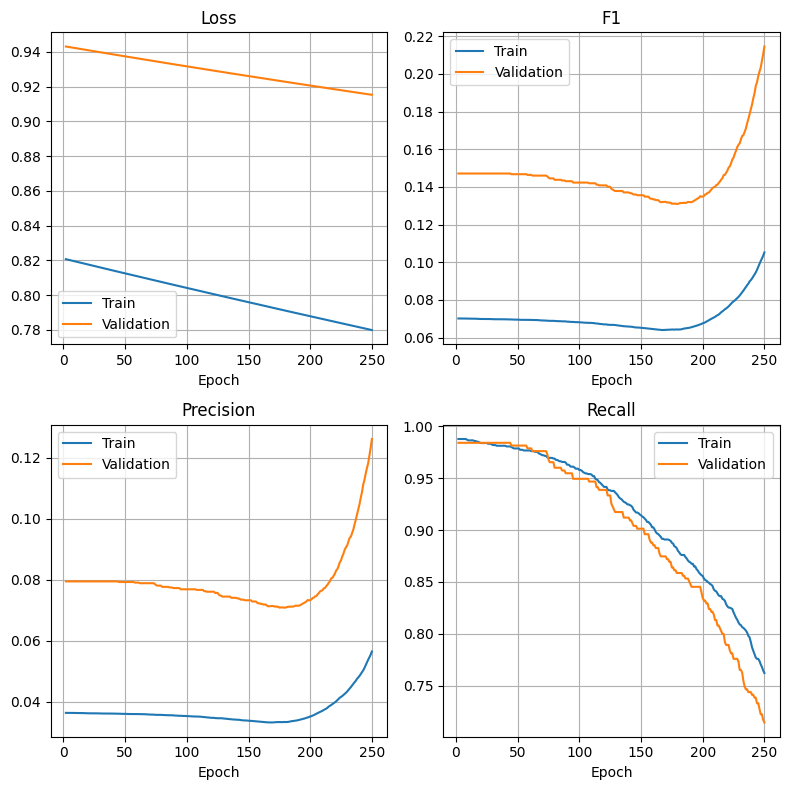

In [60]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

plt.sca(axs[0, 0])
plt.plot(res["train_loss"], label="Train")
plt.plot(res["val_loss"], label="Validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[0, 1])
plt.plot(res["train_f1"], label="Train")
plt.plot(res["val_f1"], label="Validation")
plt.title("F1")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[1, 0])
plt.plot(res["train_precision"], label="Train")
plt.plot(res["val_precision"], label="Validation")
plt.title("Precision")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[1, 1])
plt.plot(res["train_recall"], label="Train")
plt.plot(res["val_recall"], label="Validation")
plt.title("Recall")
plt.xlabel("Epoch")
plt.legend()
fig.tight_layout();

slightly worse, but works :)

### Linear attention

In [134]:
from src.transformer import LinearTransformerAnomalyDetector
from src.utils import GradNormCallback

In [126]:
window_size = 8
train_proportion = 0.9
batch_size = 2 * 4096
epochs = 150

In [127]:
seed_everything(1)

tr_dl = DataLoader(tr_dataset, batch_size=batch_size, shuffle=False)
va_dl = DataLoader(va_dataset, batch_size=batch_size, shuffle=False)

Global seed set to 1


In [128]:
seed_everything(1)

input_dim = len(tr_cols)

block_args = {
    "input_dim": 8,
    "dim_feedforward": 2 * 8,
    "num_layers": 1,
    "enable_layer_norm": False,
}
positional_encoder_args = {
    "enable": False,
    "max_len": window_size,
}

loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5))

model_params = {
    "input_dim": input_dim,
    "block_input_dim": block_args["input_dim"],
    "block_args": block_args,
    "num_layers": block_args["num_layers"],
    "positional_encoder_args": positional_encoder_args,
    "learning_rate": 1e-1,
    "dropout": 0.0,
    "loss_fn": loss_fn,
}

model = LinearTransformerAnomalyDetector(
    **model_params,
)

Global seed set to 1
layer norm disabled
positional encoding disabled


In [129]:
seed_everything(1)
trainer = pl.Trainer(
    max_epochs=epochs,
    log_every_n_steps=1,
    callbacks=[LearningRateFinder(max_lr=1e-2), MetricTracker(), GradNormCallback()],
    gradient_clip_val=1.2,
)

trainer.fit(model, tr_dl, va_dl)

Global seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.008709635899560806
Restoring states from the checkpoint path at /Users/th/Documents/icl_thesis/notebooks/.lr_find_4549a66a-9c2b-4664-85c0-7ee8ebbbfc30.ckpt
Restored all states from the checkpoint at /Users/th/Documents/icl_thesis/notebooks/.lr_find_4549a66a-9c2b-4664-85c0-7ee8ebbbfc30.ckpt

  | Name                | Type                     | Params
-----------------------------------------------------------------
0 | front_linear        | Linear                   | 24    
1 | transformer_encoder | LinearTransformerEncoder | 544   
2 | positional_encoder  | Identity                 | 0     
3 | final_linear        | Linear                   | 9     
4 | loss_fn             | BCEWithLogitsLoss        | 0     
-----------------------------------------------------------------
577       Trainable params
0         Non-trainable params
577       Total params
0.002     Total estimated model params size (MB)
Restored all st

Sanity Checking: 0it [00:00, ?it/s]

/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


In [130]:
mt = trainer.callbacks[1]

In [131]:
from copy import deepcopy

res = deepcopy(mt.collection)
for r in res:
    for k, v in r.items():
        if type(v) == torch.Tensor:
            r[k] = np.float32(v.cpu())
        else:
            r[k] = np.float32(v)
res = pd.DataFrame(res)

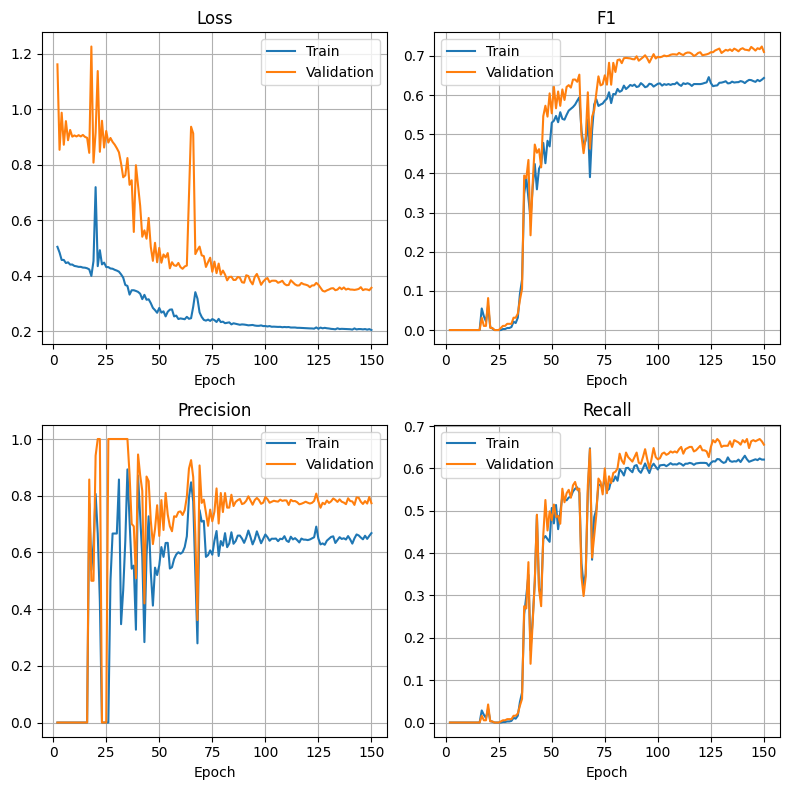

In [132]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

plt.sca(axs[0, 0])
plt.plot(res["train_loss"], label="Train")
plt.plot(res["val_loss"], label="Validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[0, 1])
plt.plot(res["train_f1"], label="Train")
plt.plot(res["val_f1"], label="Validation")
plt.title("F1")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[1, 0])
plt.plot(res["train_precision"], label="Train")
plt.plot(res["val_precision"], label="Validation")
plt.title("Precision")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[1, 1])
plt.plot(res["train_recall"], label="Train")
plt.plot(res["val_recall"], label="Validation")
plt.title("Recall")
plt.xlabel("Epoch")
plt.legend()
fig.tight_layout();

## Evaluate on all datasets

In [8]:
from pathlib import Path

ROOT_DATA_DIR = Path("../data/")

In [9]:
from src.utils import (
    get_metrics_from_tracker,
    plot_metrics_from_tracker,
    prepare_dataset_for_evaluation,
)

In [10]:
from lightning.pytorch.callbacks import LearningRateFinder

from src.utils import MetricTracker
from src.transformer import TransformerAnomalyDetector
from src.transformer import LinearRegressionAnomalyDetector
from src.utils import GradNormCallback

In [11]:
window_size = 8
train_proportion = 0.9
batch_size = 2 * 4096
epochs = 150

In [12]:
dataset_name = "KPI"
tr_dl, va_dl, tr_cols = prepare_dataset_for_evaluation(
    dataset_name=dataset_name,
    window_size=8,
    train_proportion=0.9,
    batch_size=batch_size,
    root_data_dir=ROOT_DATA_DIR,
)

# dataset_name = "FI2010"
# tr_dl, va_dl, tr_cols = prepare_dataset_for_evaluation(
#     dataset_name=dataset_name,
#     window_size=8,
#     train_proportion=0.9,
#     batch_size=batch_size,
#     root_data_dir=ROOT_DATA_DIR,
# )

# dataset_name = "NAB"
# tr_dl, va_dl, tr_cols = prepare_dataset_for_evaluation(
#     dataset_name=dataset_name,
#     window_size=8,
#     train_proportion=0.9,
#     batch_size=batch_size,
#     root_data_dir=ROOT_DATA_DIR,
# )

Global seed set to 1
y_tr mean 0.036821845918893814, y_va mean 0.08067986369132996
Global seed set to 1


In [13]:
seed_everything(1)

input_dim = len(tr_cols)

block_args = {
    "input_dim": 8,
    "num_heads": 2,
    "dim_feedforward": 2 * 8,
    "num_layers": 1,
    "enable_layer_norm": False,
}
positional_encoder_args = {
    "enable": False,
    "max_len": window_size,
}

loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5))
# loss_fn = nn.BCEWithLogitsLoss()

model_params = {
    "input_dim": input_dim,
    "block_input_dim": block_args["input_dim"],
    "block_args": block_args,
    "num_layers": block_args["num_layers"],
    "positional_encoder_args": positional_encoder_args,
    "learning_rate": 1e-1,
    "dropout": 0.0,
    "loss_fn": loss_fn,
}


model = TransformerAnomalyDetector(
    **model_params,
)

Global seed set to 1
positional encoding disabled
layer norm disabled


In [14]:
seed_everything(1)
trainer = pl.Trainer(
    max_epochs=epochs,
    log_every_n_steps=1,
    callbacks=[LearningRateFinder(), MetricTracker(), GradNormCallback()],
    # gradient_clip_val=0.01,
)

trainer.fit(model, tr_dl, va_dl)

Global seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.01445439770745928
Restoring states from the checkpoint path at /Users/th/Documents/icl_thesis/notebooks/.lr_find_1a73cf07-1b47-4500-9c3c-649ac362a432.ckpt
Restored all states from the checkpoint at /Users/th/Documents/icl_thesis/notebooks/.lr_find_1a73cf07-1b47-4500-9c3c-649ac362a432.ckpt

  | Name                | Type               | Params
-----------------------------------------------------------
0 | front_linear        | Linear             | 24    
1 | positional_encoder  | Identity           | 0     
2 | transformer_encoder | TransformerEncoder | 544   
3 | final_linear        | Linear             | 9     
4 | loss_fn             | BCEWithLogitsLoss  | 0     
-----------------------------------------------------------
577       Trainable params
0         Non-trainable params
577       Total params
0.002     Total estimated model params size (MB)
Restored all states from the checkpoint at /Users/th/Documents/i

Sanity Checking: 0it [00:00, ?it/s]

/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


In [15]:
mt = trainer.callbacks[1]

In [16]:
res = get_metrics_from_tracker(mt)

In [17]:
res.describe()

,my_model/grad_norm,val_loss,val_precision,val_recall,val_auc,val_f1,train_loss,train_precision,train_recall,train_auc,train_f1
count,150.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000
mean,16.148477,15.624621,0.712479,0.567588,0.771459,0.614143,7.132115,0.619869,0.525394,0.752262,0.548884
std,100.834341,55.604843,0.286323,0.228714,0.118919,0.254023,22.743848,0.261323,0.210779,0.110128,0.231996
min,0.000000,0.313993,0.000000,0.000000,0.294667,0.000000,0.206530,0.000000,0.000000,0.324810,0.000000
25%,0.300423,0.347199,0.787692,0.642667,0.815039,0.668874,0.208403,0.647658,0.600000,0.794206,0.610361
50%,0.316689,0.351229,0.831615,0.648000,0.818149,0.727545,0.209440,0.722696,0.605844,0.798789,0.658915
75%,0.525405,0.479080,0.850340,0.669333,0.829518,0.733234,0.416540,0.746805,0.609740,0.800091,0.665038
max,890.974609,369.096649,1.000000,0.776000,0.851778,0.776935,115.450066,1.000000,0.697403,0.823989,0.695652


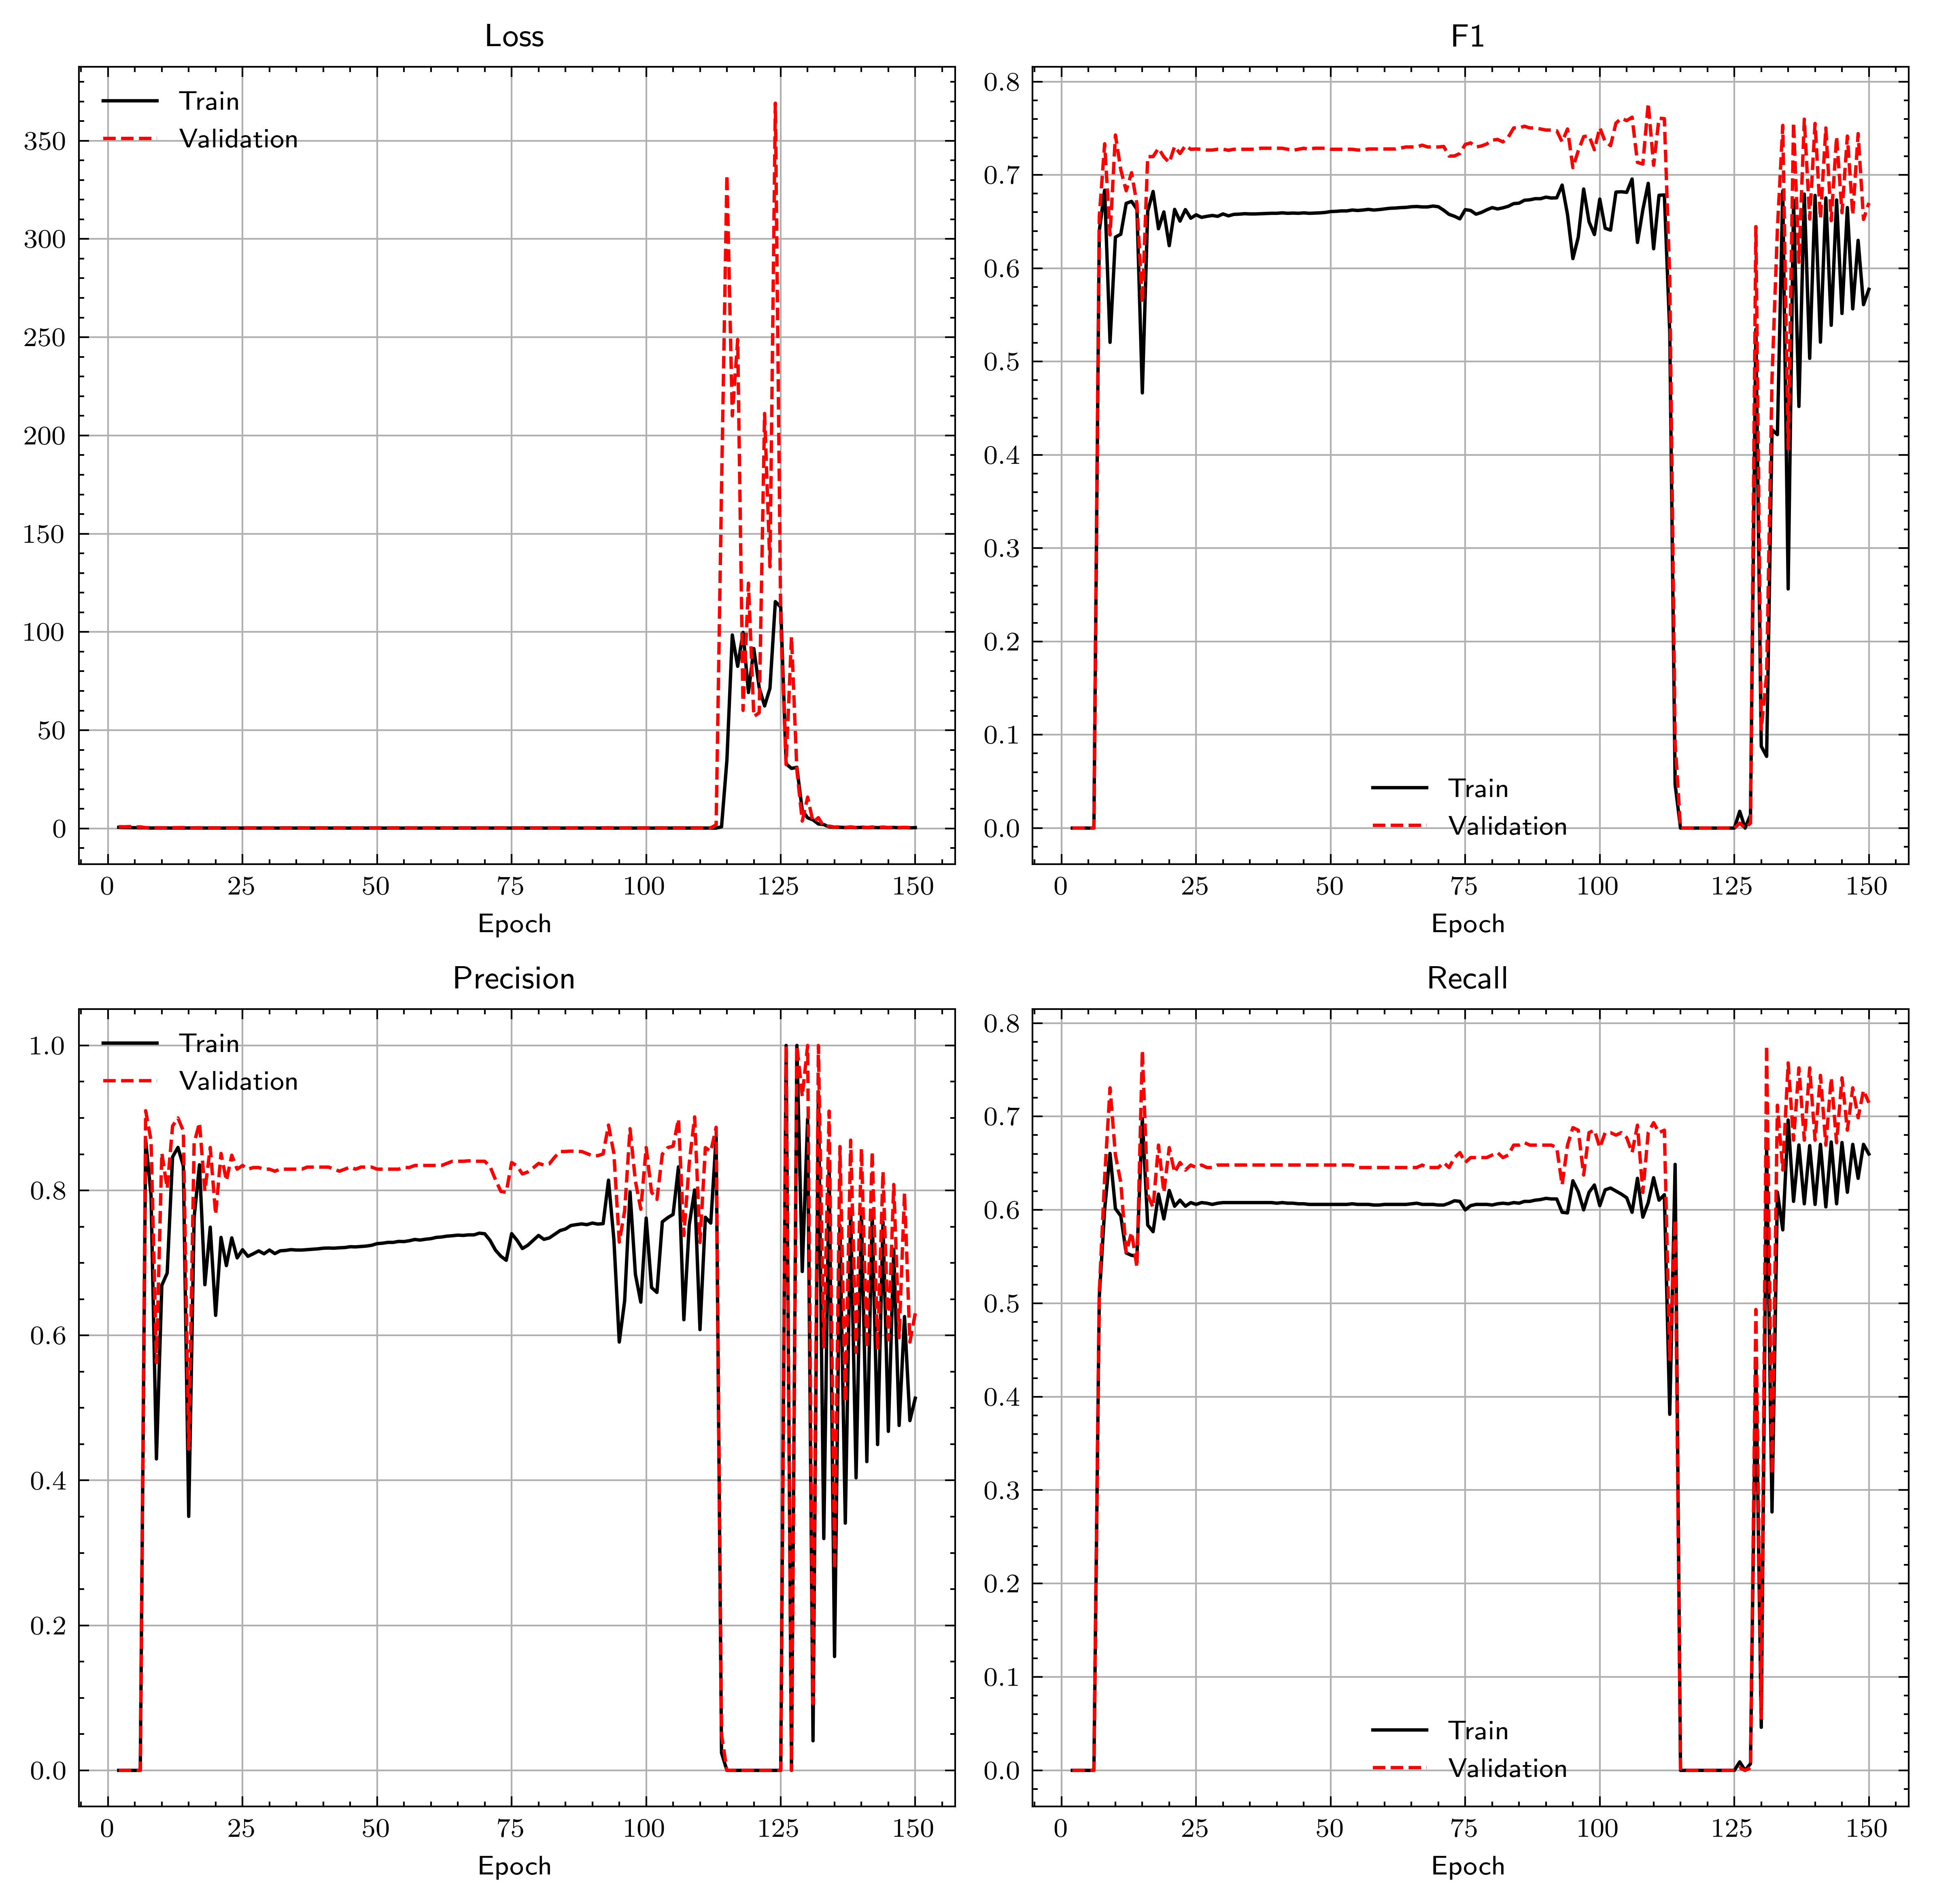

In [19]:
plot_metrics_from_tracker(res, dataset_name='', filename='../tex/Figures/gradient_explosion.png')
plt.show()